# 2016 California Election Exploration

Add documentation locally; later export as markdown file for the website 

### Overview:

Having merged census tracts in QGIS, blah blah


### Guiding Questions for this Exploration:

- Is there a voting pattern of Hispanics favoring the Hispanic candidate in single-party races? What about other demographic groups?

- What does the visualization of population density vs. candidate percentage look like?

- Counties have evolved quite differently from their original demographics. On the county level, are there any significant trends that differ between counties? Any where linear regression can be applied on each to calculate slope?

- What kind of precincts had the most split-ticket voters? Are there any trends with the delta, normalized for down-ballot drop-off, with any of the census data? Statistically, are these the district types with the most swing voters and candidates and parties should spend the greatest effort in targeting?

- What is the correlation between the candidates and propositions?

In [2]:
# Scientific Computing
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

import pickle as p

We will import the results from `election_exploration_squash_merger.ipynb`.

__This is the merged result of Precinct Election Data, ArcGIS Census data and the 2017 ACS Survey Data.__

In [23]:
# Import final dataframe

df = pd.read_csv('2016_sq_result.csv')
print(df.columns[:44])
print(df.columns[44:125])
print(df.columns[125:])

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity'],
      dtype='object')
Index(['STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT', 'BLKGRP', 'FIPS',
       'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19',


In [21]:
# Only precincts with significant data

df_sig = df[(df['pres_clinton'] > 10) & (df['pres_trump'] > 10)]

Text(0, 0.5, 'Percent vote for Sanchez')

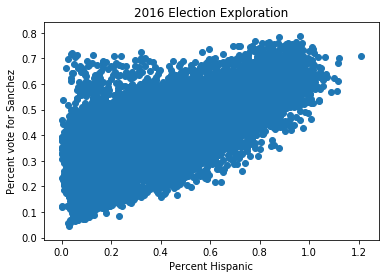

In [22]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_hispanic'], df_sig['pct_sanchez'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Sanchez')

# Sanchez is from Orange County

Text(0, 0.5, 'Percent vote for Trump')

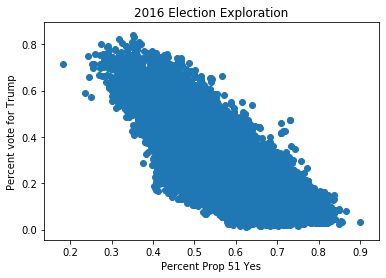

In [25]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_prop51_yes'], df_sig['pct_trump'])
plt.xlabel('Percent Prop 51 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
# Total votes: 14,610,509
# President: 14,181,595
# Registered voters: 19,411,771


Text(0, 0.5, 'Percent vote for Trump')

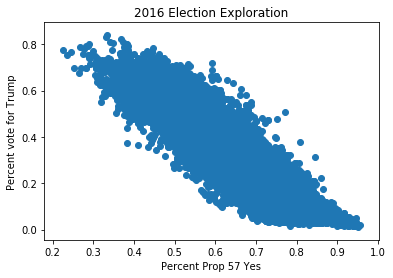

In [27]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_prop57_yes'], df_sig['pct_trump'])
plt.xlabel('Percent Prop 57 Yes')
plt.ylabel('Percent vote for Trump')

# Total votes: 13,620,436


Text(0, 0.5, 'Percent Trump')

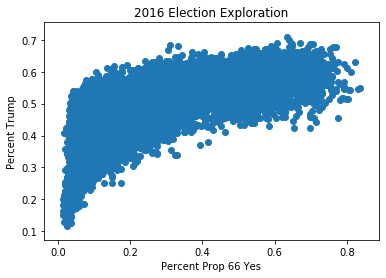

In [29]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_trump'], df_sig['pct_prop66_yes'])
plt.xlabel('Percent Prop 66 Yes')
plt.ylabel('Percent Trump')

### Background on Prop 65 and Prop 67

Text(0, 0.5, 'Percent Prop 67 Yes')

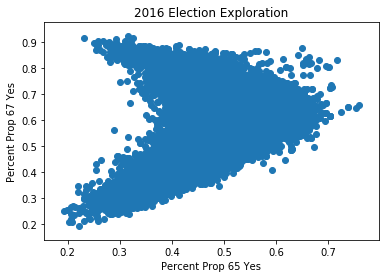

In [31]:
plt.title('2016 Election Exploration')
mask = (df[df['prop65_yes'] > 60])

plt.scatter(mask['pct_prop65_yes'], mask['pct_prop67_yes'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

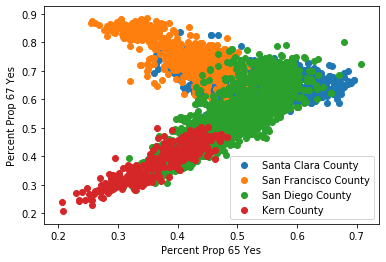

In [33]:
plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County','San Diego County','Kern County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

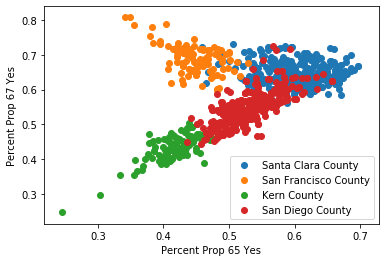

In [34]:
# new mask

mask = (df[df['pct_white'] < .2])
mask = (mask[mask['prop65_yes'] > 60])

plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County', 'Kern County','San Diego County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

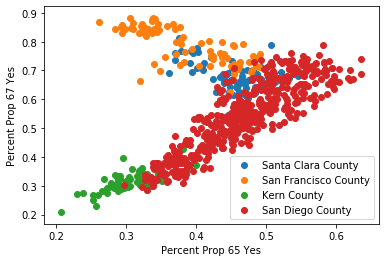

In [37]:
# new mask

mask = (df[df['pct_white'] > .7])
mask = (mask[mask['prop65_yes'] > 60])

plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County', 'Kern County','San Diego County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

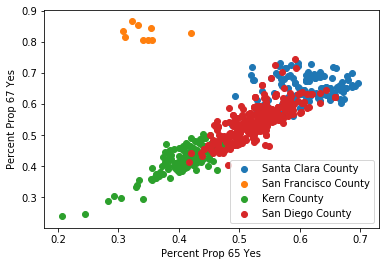

In [36]:
# new mask

mask = (df[df['pct_hispanic'] > .5])
mask = (mask[mask['prop65_yes'] > 60])

plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County', 'Kern County','San Diego County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

### Build Machine Learning Models